In [1]:
"""make variations of input image"""

import argparse, os, sys, glob
import PIL
import torch
import torch.nn as nn
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange, repeat
from torchvision.utils import make_grid
from torch import autocast
from contextlib import nullcontext
import time
from pytorch_lightning import seed_everything
import torch.nn.functional as F

sys.path.append(os.path.dirname(sys.path[0]))
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler

from transformers import CLIPProcessor, CLIPModel

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
cpu=torch.device("cpu")

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())


def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.to(device)
    model.eval()
    return model


def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((512,512), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.*image - 1.

/home/geonhui/miniconda3/envs/third_prospect_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/geonhui/miniconda3/envs/third_prospect_env/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
config="configs/stable-diffusion/v1-inference.yaml"
ckpt="models/sd/sd-v1-4.ckpt"
config = OmegaConf.load(f"{config}")
model = load_model_from_config(config, f"{ckpt}")
sampler = DDIMSampler(model)

Loading model from models/sd/sd-v1-4.ckpt
Global Step: 470000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
make_beta_schedule:linear
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.21.mlp.fc1.bias', 'vision_model.encoder.layers.9.self_attn.out_proj.bias', 'vision_model.encoder.layers.1.self_attn.q_proj.weight', 'vision_model.encoder.layers.11.self_attn.k_proj.weight', 'vision_model.encoder.layers.15.self_attn.out_proj.weight', 'vision_model.encoder.layers.23.self_attn.v_proj.bias', 'vision_model.encoder.layers.12.mlp.fc1.bias', 'vision_model.encoder.layers.7.self_attn.out_proj.weight', 'vision_model.encoder.layers.19.mlp.fc1.weight', 'vision_model.encoder.layers.6.layer_norm2.weight', 'vision_model.encoder.layers.21.layer_norm1.bias', 'vision_model.encoder.layers.13.self_attn.q_proj.bias', 'vision_model.encoder.layers.20.mlp.fc2.bias', 'vision_model.encoder.layers.4.layer_norm2.bias', 'vision_model.encoder.layers.5.mlp.fc1.bias', 'vision_model.encoder.layers.11.mlp.fc1.weight', 'vision_model.encoder.layers.1.mlp.fc1.we

In [4]:
def main(prompt = '', content_dir = None,ddim_steps = 50,strength = 0.5, ddim_eta=0.0, n_iter=1, C=4, f=8, n_rows=0, scale=10.0, \
         model = None, seed=42, prospect_words = None, n_samples=1, height=512, width=512):
    
    precision="autocast"
    outdir="outputs/img2img-samples"
    seed_everything(seed)


    os.makedirs(outdir, exist_ok=True)
    outpath = outdir

    batch_size = n_samples
    n_rows = n_rows if n_rows > 0 else batch_size
    data = [batch_size * [prompt]]


    sample_path = os.path.join(outpath, "samples")
    os.makedirs(sample_path, exist_ok=True)
    base_count = len(os.listdir(sample_path))
    grid_count = len(os.listdir(outpath)) + 10
    
    if content_dir is not None:
        content_name =  content_dir.split('/')[-1].split('.')[0]
        content_image = load_img(content_dir).to(device)
        content_image = repeat(content_image, '1 ... -> b ...', b=batch_size)
        content_latent = model.get_first_stage_encoding(model.encode_first_stage(content_image))  # move to latent space

        init_latent = content_latent

    sampler.make_schedule(ddim_num_steps=ddim_steps, ddim_eta=ddim_eta, verbose=False)

    assert 0. <= strength <= 1., 'can only work with strength in [0.0, 1.0]'
    t_enc = int(strength * ddim_steps)
    print(f"target t_enc is {t_enc} steps")

    precision_scope = autocast if precision == "autocast" else nullcontext
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                tic = time.time()
                all_samples = list()
                for n in trange(n_iter, desc="Sampling"):
                    for prompts in tqdm(data, desc="data"):
                        uc = None
                        if scale != 1.0:
                            uc = model.get_learned_conditioning(batch_size * [""])
                        if isinstance(prompts, tuple):
                            prompts = list(prompts)
                        
                        c= model.get_learned_conditioning(prompts, prospect_words=prospect_words)         
                                
                        

                        # img2img
#                         z_enc = sampler.stochastic_encode(init_latent, torch.tensor([t_enc]*batch_size).to(device))
#                         t_enc = int(strength * ddim_steps)
#                         samples = sampler.decode(z_enc, c, t_enc, 
#                                                 unconditional_guidance_scale=scale,
#                                                  unconditional_conditioning=uc,)
#                         print(z_enc.shape, uc.shape, t_enc)

#                         txt2img    
                        shape=[4, int(height/8), int(width/8)]
                        samples, intermediates = sampler.sample(S=ddim_steps,
                                                         conditioning=c,
                                                         batch_size=batch_size,
                                                         shape=shape,
                                                         verbose=False,
                                                         eta=ddim_eta,
                                                        #  log_every_t=50, # to see the intermediate predicted image
                                                         unconditional_guidance_scale=scale,
                                                         unconditional_conditioning=uc)
                    
                        x_samples = model.decode_first_stage(samples)

                        x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                        for x_sample in x_samples:
                            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                            base_count += 1
                        all_samples.append(x_samples)

                # additionally, save as grid
                grid = torch.stack(all_samples, 0)
                grid = rearrange(grid, 'n b c h w -> (n b) c h w')
                grid = make_grid(grid, nrow=n_rows)

                # to image
                grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
                output = Image.fromarray(grid.astype(np.uint8))
#                 output.save(os.path.join(outpath, content_name+'-'+prompt+f'-{grid_count:04}.png'))
                # Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'grid-{grid_count:04}.png'))
                grid_count += 1

                toc = time.time()
    return output

In [22]:
model.cpu()
#model.embedding_manager.load('./logs/example_images2023-09-01T21-26-01_bird/checkpoints/embeddings_gs-599.pt')
model.embedding_manager.load('./logs/bear_folder2023-09-02T16-10-26_bear/checkpoints/embeddings.pt')
model = model.to(device)

In [23]:
main(prompt = '*', \
      ddim_steps = 50, \
      strength = 0.6, \
      seed=42, \
      height = 512, \
      width = 768, \
      prospect_words = ['a teddy * walking in times square', # 10 generation ends\
                           'a teddy * walking in times square', # 9 \
                           'a teddy * walking in times square', # 8 \
                           'a teddy * walking in times square', # 7 \
                           'a teddy * walking in times square', # 6 \
                           'a teddy * walking in times square', # 5 \
                           'a teddy * walking in times square', # 4 \
                           'a teddy * walking in times square', # 3 \
                           'a teddy walking in times square', # 2 \
                           'a teddy walking in times square', # 1 generation starts\
                          ], \
      model = model,\
      )

Global seed set to 42


target t_enc is 30 steps


Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

batch 1
Working with IMGAE GUIDING mode
Find Words: ['a teddy * walking in times square', 'a teddy * walking in times square', 'a teddy * walking in times square', 'a teddy * walking in times square', 'a teddy * walking in times square', 'a teddy * walking in times square', 'a teddy * walking in times square', 'a teddy * walking in times square', 'a teddy walking in times square', 'a teddy walking in times square']
batch 1
Working with IMGAE GUIDING mode
Find word list: ['a teddy * walking in times square', 'a teddy * walking in times square', 'a teddy * walking in times square', 'a teddy * walking in times square', 'a teddy * walking in times square', 'a teddy * walking in times square', 'a teddy * walking in times square', 'a teddy * walking in times square', 'a teddy walking in times square', 'a teddy walking in times square']
Data shape for DDIM sampling is (1, 4, 64, 96), eta 0.0
Running DDIM Sampling with 50 timesteps




Sampling:   0%|          | 0/1 [00:28<?, ?it/s]


KeyboardInterrupt: 

Global seed set to 41


target t_enc is 30 steps


Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

batch 1
Working with IMGAE GUIDING mode
Find Words: ['a * dog on the grass', 'a * dog on the grass', 'a * dog on the grass', 'a * dog on the grass', 'a * dog on the grass', 'a * dog on the grass', 'a dog on the grass', 'a dog on the grass', 'a dog on the grass', 'a dog on the grass']
batch 1
Working with IMGAE GUIDING mode
Find word list: ['a * dog on the grass', 'a * dog on the grass', 'a * dog on the grass', 'a * dog on the grass', 'a * dog on the grass', 'a * dog on the grass', 'a dog on the grass', 'a dog on the grass', 'a dog on the grass', 'a dog on the grass']
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Running DDIM Sampling with 50 timesteps





















































Sampling: 100%|██████████| 1/1 [00:08<00:00,  8.85s/it]


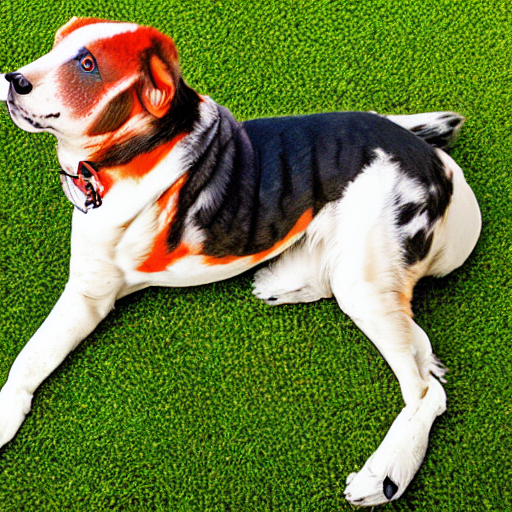

In [21]:
main(prompt = '*', \
     # content_dir = './dataset/teddy.jpg', \
     ddim_steps = 50, \
     strength = 0.6, \
     seed=41, \
     height = 512, \
     width = 512, \
     prospect_words = ['a * dog on the grass',  # 10 generation ends\ 
                          'a * dog on the grass',  # 9 \
                          'a * dog on the grass',  # 8 \
                          'a * dog on the grass',  # 7 \ 
                          'a * dog on the grass',  # 6 \ 
                          'a * dog on the grass',  # 5 \
                          'a dog on the grass',  # 4 \
                          'a dog on the grass',  # 3 \
                          'a dog on the grass',  # 2 \
                          'a dog on the grass',  # 1 generation starts\ 
                         ], \
     model = model,\
     )